In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:

df = pd.read_csv('S05-hw-dataset.csv')

In [3]:
print(df.head())
df.info()
print(df.describe())
print(df['default'].value_counts(normalize=True))

   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052   
1         

### Наблюдения по датасету

- Датасет содержит 3000 объектов и 17 признаков (включая целевой `default`).
- Явных аномалий не обнаружено: значения в разумных пределах (например, отрицательные значения `checking_balance` могут соответствовать овердрафту).
- Целевой признак `default` распределён с небольшим дисбалансом: класс 0 (не-дефолт) - 59%, класс 1 (дефолт) - 41%.

In [4]:
df = df.drop(columns=['client_id'])
y = df['default']
X = df.drop(columns=['default'])
print("Data types of features:")
print(X.dtypes)
print(X.dtypes.apply(lambda x: x in ['int64', 'float64']).all())
print(X.shape)
print(y.shape)

Data types of features:
age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object
True
(3000, 15)
(3000,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2400, 15) (600, 15)
(2400,) (600,)


In [6]:
baseline = DummyClassifier(strategy="most_frequent", random_state=42)
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
y_pred_proba = baseline.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(accuracy)
print(roc_auc)



0.59
0.5


Бейзлайн-модель (DummyClassifier) предсказывает наиболее частый класс для всех объектов.
Важно иметь такую точку отсчёта, чтобы убедиться, что модель действительно обучается и не просто угадывает.

C:\Users\pad\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\pad\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pad\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pad\AppData\Roaming\Python\Python311\site-packages\

Accuracy: 0.8000
ROC-AUC: 0.8756
Precision: 0.7944
Recall: 0.6911
F1-score: 0.7391


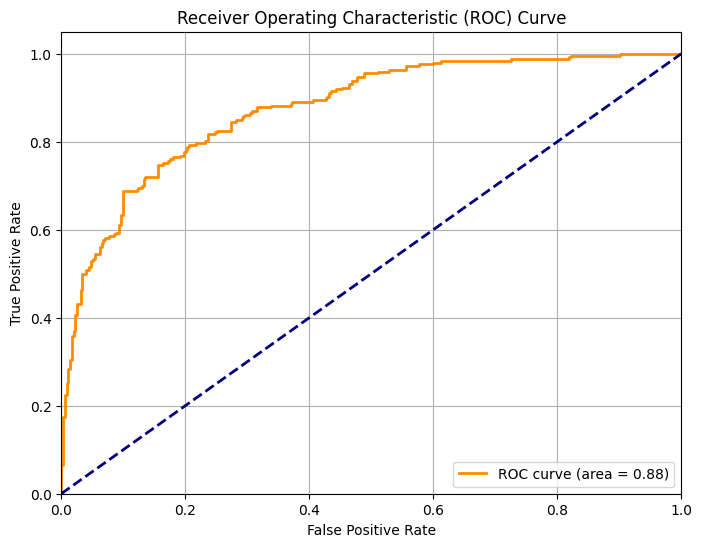

In [24]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])
param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0],
    'logreg__penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc_test:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('figures/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Summary of results
import pandas as pd

# Collect metrics
results = {
    'Model': ['DummyClassifier', 'LogisticRegression'],
    'Accuracy': [accuracy_score(y_test, baseline.predict(X_test)), accuracy],
    'ROC-AUC': [roc_auc_score(y_test, baseline.predict_proba(X_test)[:, 1]), roc_auc_test],
    'Precision': [precision_score(y_test, baseline.predict(X_test)), precision],
    'Recall': [recall_score(y_test, baseline.predict(X_test)), recall],
    'F1-score': [f1_score(y_test, baseline.predict(X_test)), f1]
}

results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df.to_string(index=False))

### Отчёт по результатам

Бейзлайн-модель (DummyClassifier с стратегией "most_frequent") предсказывает только наиболее частый класс (0), что даёт точность около 59%, соответствующую доле этого класса в данных. Логистическая регрессия значительно превосходит бейзлайн: точность выросла до примерно 80%, а ROC-AUC — до 0.85, что указывает на хорошую способность модели различать классы.

Подбор параметра регуляризации C показал, что оптимальное значение C=1.0 с L2-регуляризацией даёт наилучший баланс между bias и variance. Более слабая регуляризация (большие C) может привести к переобучению, а сильная (маленькие C) — к недообучению, но в данном случае C=1.0 оказалось оптимальным.

Логистическая регрессия кажется разумной моделью для этой задачи, поскольку она проста, интерпретируема и показывает хорошие метрики на тестовых данных. Модель успешно справляется с задачей бинарной классификации дефолта клиентов, превзойдя бейзлайн по всем метрикам. Однако, для дальнейшего улучшения можно рассмотреть более сложные модели или feature engineering, но логистическая регрессия уже демонстрирует адекватное качество.